## Pixel classification using sci-kit learn
- image set BBBC038v1, available from the Broad Bioimage Benchmark Collection Caicedo et al., Nature Methods, 2019. link {https://bbbc.broadinstitute.org/BBBC007}
- Source of guide: Robert Haase, Guillaume Witz, Miguel Fernandes, Marcelo Leomil Zoccoler, Shannon Taylor, Mara Lampert, Till Korte


Import libraries

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from skimage.io import imread, imshow
import numpy as np
import napari
from skimage import filters
import matplotlib.pyplot as plt

Load sample

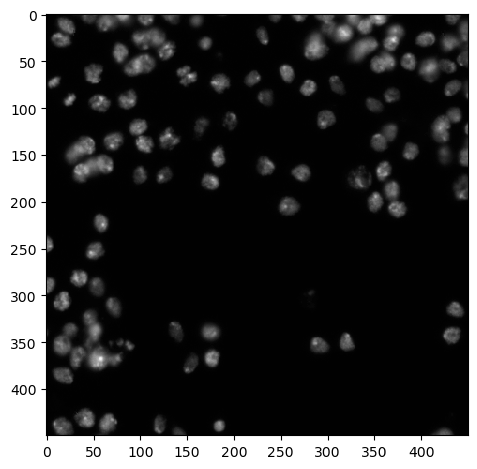

In [2]:
# img = imread('input_data/blobs.tif')
img = imread("BBBC007_v1_images/A9/A9 p5d.tif")
imshow(img)

Generate feature stack

In [3]:
from skimage import filters


def generate_feature_stack(image):
    # Determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # ravel() function turns nD img into 1D image
    # scikit-learn expects values in 1D format
    feature_stack = [image.ravel(), blurred.ravel(), edges.ravel()]

    # return stack as numpy.array
    return np.asarray(feature_stack)

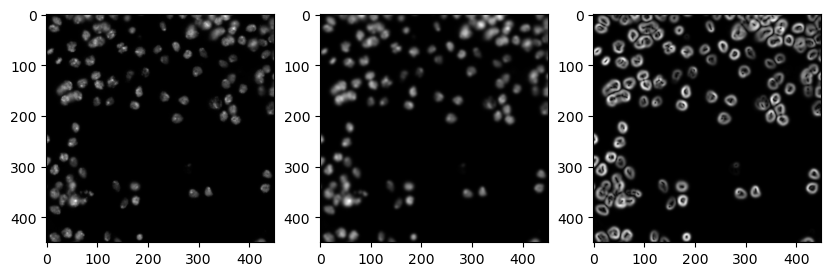

In [4]:
feature_stack = generate_feature_stack(img)

# show feature images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(feature_stack[0].reshape(img.shape), cmap=plt.cm.gray)
axes[1].imshow(feature_stack[1].reshape(img.shape), cmap=plt.cm.gray)
axes[2].imshow(feature_stack[2].reshape(img.shape), cmap=plt.cm.gray)

Interactive annotations

In [5]:
# %% Manual annotations with Napari

# start napari
viewer = napari.Viewer()
# add image
viewer.add_image(img)
# add an empty labels layer and keet it in a variable
labels = viewer.add_labels(np.zeros(img.shape).astype(int))


# && Take screenshot
# napari.utlis.nbscreenshot(viewer)

Retrieve annotations

/home/jaz/.local/minimamba/envs/img_seg/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


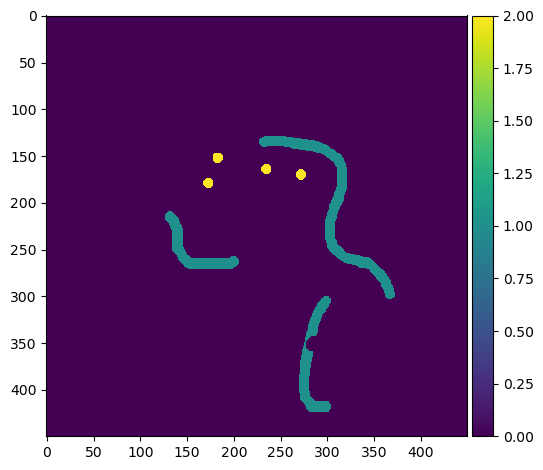

In [8]:
annotations = labels.data

imshow(annotations, vmin=0, vmax=2)

Format data
- Scikit learn input: 
    - array of shape (n,m) n= number pixels, m = number features 
    - annotations (n)

In [9]:
def format_data(feature_stack, annotations):
    # reformat data to match scikit input
    # transpose feature stack
    x = feature_stack.T
    # make annotation 1D
    y = annotations.ravel()

    # remove all pixels from the feature and annotations whicn haven't been annotated
    mask = y > 0
    x = x[mask]
    y = y[mask]

    return x, y


# x, y = format_data(feature_stack, annotations)
# print("input_shape", x.shape)
# print("annotation shape", y.shape)

input_shape (6152, 3)
annotation shape (6152,)


Generate features, train classifier, add results to img label

In [11]:
# %% Generate features
feature_stack = generate_feature_stack(img)
X, y = format_data(feature_stack, annotations)
print("input_shape", x.shape)
print("annotation shape", y.shape)

input_shape (6152, 3)
annotation shape (6152,)


In [12]:
# train classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)  # feature stack X, annotations y

RandomForestClassifier(max_depth=2, random_state=0)

/home/jaz/.local/minimamba/envs/img_seg/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


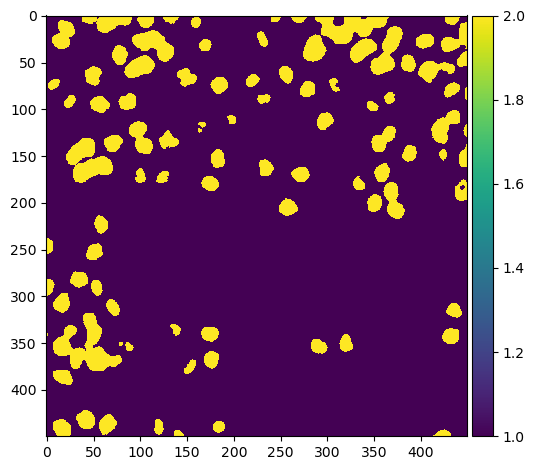

In [13]:
# process the whole image and show result
result_1d = classifier.predict(feature_stack.T)
result_2d = result_1d.reshape(img.shape)
imshow(result_2d)

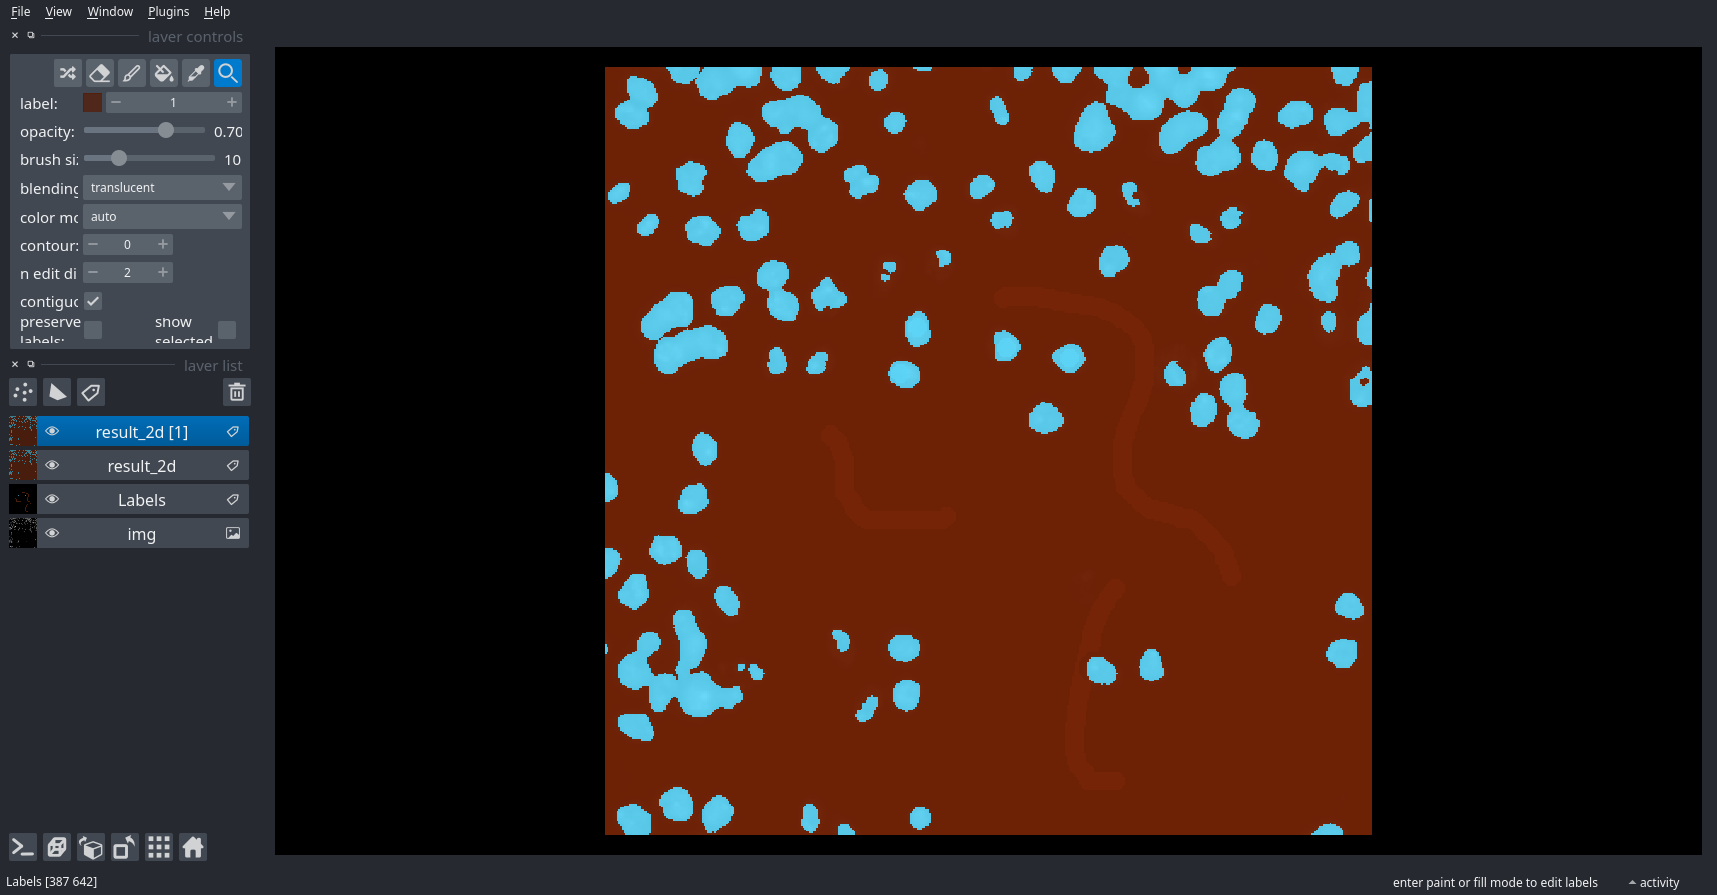

In [14]:
# %% Add the result to napari.
viewer.add_labels(result_2d)
napari.utils.nbscreenshot(viewer)